In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
from scipy.stats import uniform,norm

Generate synthetic lightcurve with count rate being r'=r+gamma\*sigma 

where sigma is flux error from original lc.*

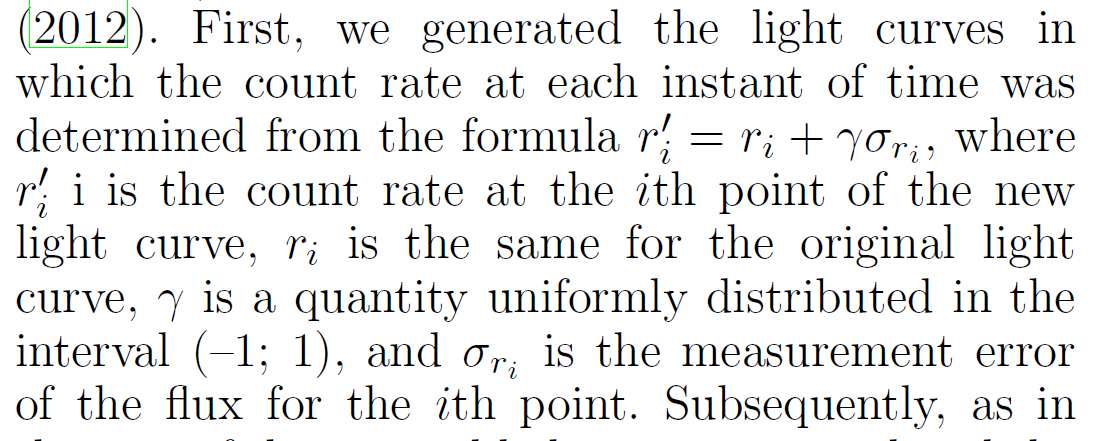

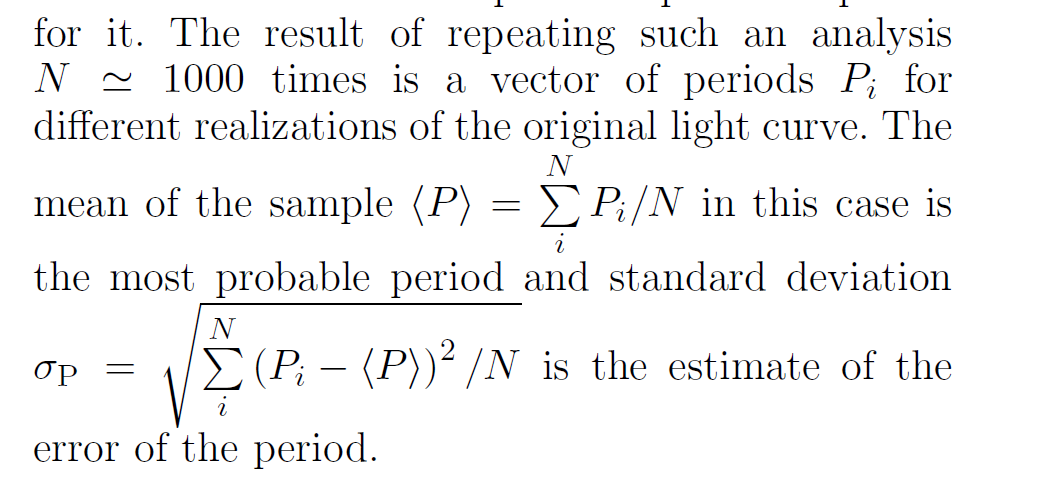



In [137]:
def generate_synthetic_light_curves(input_fits, output_folder, num_synthetic_curves):
    # Extract observation ID from the input file path (assumes folder name is observation ID)
    obs_id = input_fits.split('/')[1]

    # Create a specific output directory for the synthetic light curves and best_fit_period.txt
    output_dir = os.path.join(output_folder, obs_id)
    os.makedirs(output_dir, exist_ok=True)

    # Path for storing the best fit period file for the current obs_id
    best_fit_period_file = os.path.join(output_dir, 'best_fit_period_0.1bin_100.txt')

    # Open the input FITS file
    with fits.open(input_fits) as hdul:
        rate_data = hdul['RATE'].data
        time = rate_data['TIME']
        rate = rate_data['RATE']
        error = rate_data['ERROR']


        # Generate synthetic light curves and run efsearch
        for i in range(num_synthetic_curves):
            synthetic_rate = np.zeros_like(rate)  # Initialize array for synthetic rate
            for j in range(len(rate)):
                #gamma_j = np.random.uniform(-8, 8)  # Numpy uniform
                gamma_j = uniform.rvs(loc=-error[j], scale=2*error[j])  # Scipy uniform
                
                synthetic_rate[j] = rate[j] + gamma_j*error[j] # Apply to each bin individually
                # if(synthetic_rate[j])<0: ##Forcing 0 for gaussian variation negative values
                #     synthetic_rate[j]=0
            # Create a new synthetic FITS file
            output_fits = os.path.join(output_dir, f'synthetic_light_curve_{i+1}.fits')

            hdul_new = hdul.copy()
            hdul_new['RATE'].data['RATE'] = synthetic_rate

            hdul_new.writeto(output_fits, overwrite=True)

            # Run efsearch on the synthetic light curve
            efsearch_cmd = f'efsearch {output_fits} window=- sepoch=INDEF dper=9.81 nphase=64 nbint=INDEF dres=0.0001 nper=1024 plot=no outfile={output_folder}/{obs_id}/testing_efsearch.fes'
            try:
                subprocess.run(efsearch_cmd, shell=True, check=True)

                # Open the .fes FITS file and extract the best-fit period
                with fits.open(f'{output_folder}/{obs_id}/testing_efsearch.fes') as efsearch_fits:
                    results_data = efsearch_fits['RESULTS'].data
                    max_chisq_index = np.argmax(results_data['CHISQRD1'])
                    best_fit_period = results_data['PERIOD'][max_chisq_index]
                    chisq_max=results_data['CHISQRD1'][max_chisq_index]

                # Write the light curve name and best-fit period to the individual output file
                with open(best_fit_period_file, 'a') as f_out:
                    f_out.write(f"{output_fits}\t{best_fit_period}\t{chisq_max}\n")
                print(f"Processed {output_fits}, Best-fit period: {best_fit_period}")

            except subprocess.CalledProcessError as e:
                print(f"Error processing {output_fits}: {e}")

            # Delete the synthetic FITS file to save space
            os.remove(output_fits)
            print(f"Deleted synthetic light curve {i+1} to save space.")

def read_light_curve_paths(base_dir):
    light_curve_paths = []

    for obs_id in os.listdir(base_dir):
        obs_dir = os.path.join(base_dir, obs_id)

        if os.path.isdir(obs_dir):  # Check if it's a directory
            input_fits_path = os.path.join(obs_dir, 'xti', 'event_cl', f'ni{obs_id}_cl_night_barycorrmpu7_sr_night_0.1.lc')

            if os.path.isfile(input_fits_path):  # Check if the light curve file exists
                light_curve_paths.append(input_fits_path)

    return light_curve_paths

In [138]:
if __name__ == "__main__":
    # Base directory containing observation ID folders
    base_dir = './'
    output_folder = './bootstrap_error/'

    # Number of synthetic light curves to generate
    num_synthetic_curves = 100
    # Read light curve paths
    light_curve_paths = read_light_curve_paths(base_dir)

        
    # Generate synthetic light curves for all light curve files found and run efsearch
    for path in light_curve_paths:
        generate_synthetic_light_curves(path, output_folder, num_synthetic_curves)

    print("Finished processing all light curves.")

 
efsearch 1.1 (xronos6.0)
 
 Series 1 file    1:./bootstrap_error/6050390204/synthetic_light_curve_1.fits
 
 Selected FITS extensions: 1 - RATE TABLE;
 
 Source ............ Swift_J0243.6+61    Start Time (d) .... 20047 00:47:21.284
 FITS Extension ....  1 - `RATE      `   Stop Time (d) ..... 20047 19:27:11.084
 No. of Rows .......        22130        Bin Time (s) ......   0.1000
 Right Ascension ... 40.9186             Internal time sys.. Converted to TJD
 Declination ....... 61.4323             Experiment ........ NICER    XTI
 
 Corrections applied: Vignetting - No ; Deadtime - No ; Bkgd - No ; Clock - Yes
 
 Selected Columns:  1- Time;  2- Y-axis;  3- Y-error;  4- Fractional exposure;
 
 File contains binned data.
 
 
 Expected Start ... 20047.03288523148  (days)       0:47:21:284  (h:m:s:ms)
 Expected Stop .... 20047.81054495370  (days)      19:27:11: 84  (h:m:s:ms)
 
 Default Epoch is:  20047.00000
Type INDEF to accept the default value
 Epoch format is days.
 Period format is s

### comparing light curves to check

In [2]:
def are_light_curves_different(rate1, rate2, tolerance=1e-6):
    # Compute element-wise absolute difference
    diff = np.abs(rate1 - rate2)
    
    # Check if all differences are smaller than the tolerance
    if np.all(diff < tolerance):
        return False  # They are the same within the tolerance
    else:
        return True   # They are different
    
# with fits.open('./bootstrap_error/6050390201/synthetic_light_curve_11.fits') as hdul:
#         rate_data = hdul['RATE'].data
#         time = rate_data['TIME']
#         rate1 = rate_data['RATE']
#         error1 = rate_data['ERROR']
with fits.open('./6050390204/xti/event_cl/ni6050390204_cl_night_barycorrmpu7_sr_night_0.1.lc') as hdul:
        rate_data = hdul['RATE'].data
        time = rate_data['TIME']
        rate2 = rate_data['RATE']
        error2 = rate_data['ERROR']

# if are_light_curves_different(rate1, rate2):
#     print("The two light curves are different.")
# else:
#     print("The two light curves are identical or nearly identical.")

In [12]:
gamma = np.random.uniform(-1, 1, size=len(rate2))
synthetic_rate=rate2+gamma*error2
synthetic_rate2 = np.zeros_like(rate2)  # Initialize array for synthetic rate
for j in range(len(rate2)):
    gamma_j = np.random.uniform(-1, 1)  # Generate a new random number for each bin
    synthetic_rate2[j] = rate2[j]+gamma_j*error2[j] 

gamma = np.random.uniform(-1, 1, size=len(rate2))
synthetic_rate3=rate2+gamma*error2

gamma = np.random.uniform(-1, 1, size=len(rate2))
synthetic_rate4=rate2+gamma*error2

synthetic_rate5 = np.zeros_like(rate2)  # Initialize array for synthetic rate
for j in range(len(rate2)):
    gamma_j = np.random.uniform(-1, 1)  # Generate a new random number for each bin
    synthetic_rate5[j] = rate2[j]+gamma_j*error2[j] 

synthetic_rate6 = np.zeros_like(rate2)  # Initialize array for synthetic rate
for j in range(len(rate2)):
    gamma_j = np.random.normal(rate2[j], error2[j])  # Generate a new random number for each bin
    synthetic_rate6[j] = gamma_j
    if synthetic_rate6[j] < 0:
        synthetic_rate6[j] = 0


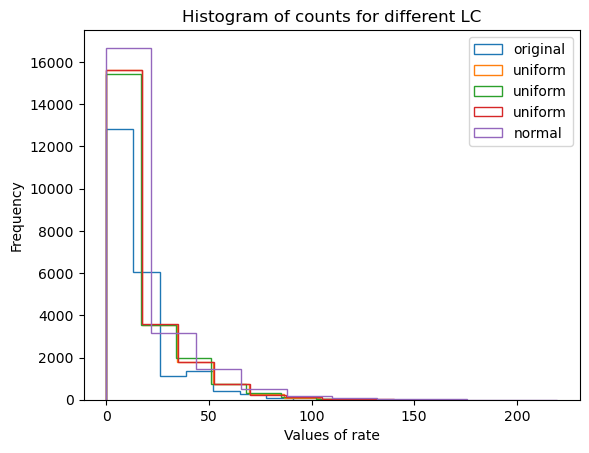

In [17]:
plt.hist(rate2,histtype='step',bins=10,label='original')
plt.hist(synthetic_rate,histtype='step',bins=10, label='uniform')
plt.hist(synthetic_rate3,histtype='step',bins=10, label='uniform')
#plt.hist(synthetic_rate4,histtype='step',bins=10, label='uniform')
##Using looped creation
plt.hist(synthetic_rate2,histtype='step',bins=10, label='uniform')
#plt.hist(synthetic_rate5,histtype='step',bins=10,label='uniform')
plt.hist(synthetic_rate6,histtype='step',bins=10,label='normal')
plt.legend()
plt.title('Histogram of counts for different LC')
plt.xlabel('Values of rate')
plt.ylabel('Frequency')
plt.show()

In [126]:
# synthetic_rate = np.zeros_like(rate2)
# for j in range(len(rate2)):
#     gamma_j = np.random.uniform(-1, 1)  # Ensure randomness in each bin
#     synthetic_rate[j] = rate2[j] + gamma_j * error2[j]

# # Add small random offset to the entire synthetic light curve
# random_offset = np.random.normal(0, 0.01)
# synthetic_rate += random_offset 

In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(rate2,synthetic_rate,0.4,alpha=0.5)
plt.scatter(rate2,synthetic_rate2,0.4,alpha=0.5)
plt.scatter(rate2,synthetic_rate3,0.4,alpha=0.5)
plt.scatter(rate2,synthetic_rate4,0.1, alpha=0.5)
plt.grid()
# plt.xlim([1000,1050])

## Diagnosing Randomization

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import pearsonr,spearmanr

# Open the actual light curve FITS file
with fits.open('./6050390204/xti/event_cl/ni6050390204_cl_night_barycorrmpu7_sr_night_0.01.lc') as hdul:
    rate_data = hdul['RATE'].data
    time = rate_data['TIME']  # Time array from FITS file
    rate = rate_data['RATE']  # Original rate array
    error = rate_data['ERROR']  # Error array

# Number of synthetic curves
num_synthetic_curves = 500  # Specify how many synthetic curves to generate
synthetic_curves = []

# Generate synthetic light curves
for i in range(num_synthetic_curves):

    # Generate random gamma values from a normal distribution
    gamma_values = np.random.uniform(-1,1, size=len(rate))
    #random_values=np.random.normal(0,1,size=len(rate))
    
    synthetic_rate = [max(r + g * e, 0) for r, g, e in zip(rate, gamma_values, error)]
    synthetic_curves.append(synthetic_rate)

# Convert synthetic curves to a NumPy array for easier manipulation
synthetic_curves = np.array(synthetic_curves)

# Check correlation between each synthetic light curve and the one just before it
correlation_results = []
spearman_correlations = []

for i in range(1, num_synthetic_curves):
    corr_coeff, _ = pearsonr(synthetic_curves[i], synthetic_curves[i - 1])
    spearman_corr, _ = spearmanr(synthetic_curves[i], synthetic_curves[i - 1])
    correlation_results.append(corr_coeff)
    spearman_correlations.append(spearman_corr)
    #print(f"Correlation between Curve {i} and Curve {i-1}: {corr_coeff:.4f}")
print('done')

done


Text(0, 0.5, 'pearsonr coeff.')

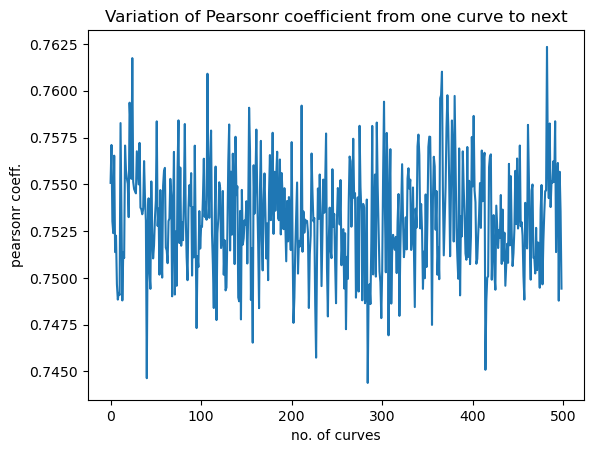

In [30]:
plt.plot(correlation_results)
plt.title("Variation of Pearsonr coefficient from one curve to next")
plt.xlabel('no. of curves')
plt.ylabel('pearsonr coeff.')

Text(0, 0.5, 'spearmanr coeff.')

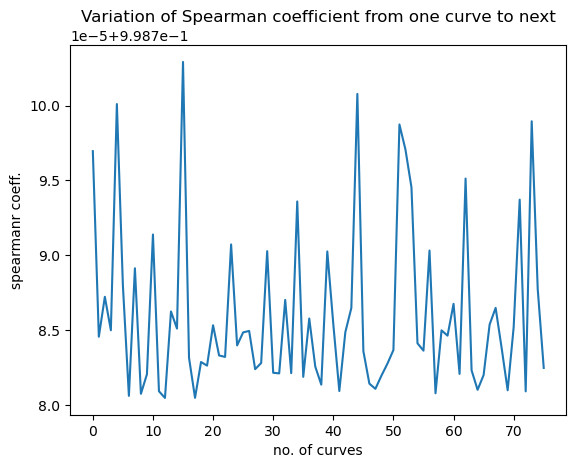

In [52]:
spearman_correlations=np.array(spearman_correlations)
plt.plot(spearman_correlations[spearman_correlations>0.99878])
plt.title("Variation of Spearman coefficient from one curve to next")
plt.xlabel('no. of curves')
plt.ylabel('spearmanr coeff.')